## 导包

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_val_predict
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

## 数据读取

In [3]:
df_train = pd.read_csv("../data/train.csv", encoding="utf-8", index_col='Id')  # 读取csv表格文件为DataFrame
df_test = pd.read_csv("../data/test.csv", encoding="utf-8", index_col='Id')

## 目标转化

In [4]:
y = np.log(df_train.SalePrice)
x_train = df_train.drop(columns=["SalePrice"])

## 数据填充 

In [5]:
numeric_columns = [col for col in x_train.columns if x_train[col].dtype != "object"]  # 取出数值列用0填充

def transform(x):
    x = x.fillna(0)
    x = x.join(np.sqrt(x[numeric_columns]), rsuffix="_SQRT")
    x = pd.get_dummies(x)
    return x

In [6]:
x_train_filled = transform(x_train)

## 离群点分析 

In [7]:
cv_errors = np.abs(cross_val_predict(BayesianRidge(), x_train_filled, y, n_jobs=-1, cv=10) - y)
outliers = list(cv_errors[cv_errors > (np.mean(cv_errors) + 2*np.std(cv_errors))].index)
x_train_filled = x_train_filled.drop(outliers)
y = y.drop(outliers)
final_model = BayesianRidge().fit(x_train_filled, y)

## 训练集预测

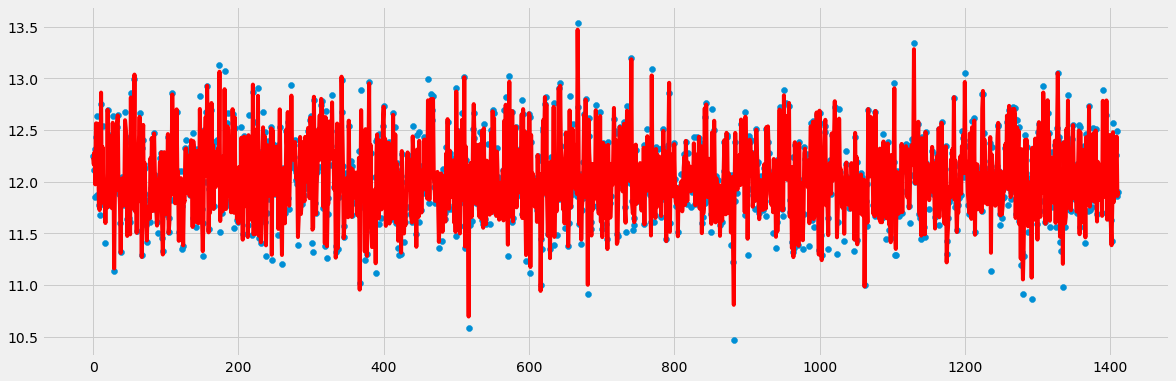

In [16]:
pred_train = final_model.predict(x_train_filled)
plt.figure(figsize=(18, 6))
plt.scatter(np.arange(len(y)), y)
plt.plot(np.arange(len(pred_train)), pred_train, color='r')
plt.show()

## 测试集处理

In [14]:
x_test = transform(df_test)
x_test = pd.DataFrame({col: x_test.get(col, 0) for col in x_train_filled.columns})

## 预测

In [15]:
pred = np.exp(final_model.predict(x_test))

## 提交

In [19]:
df_submit = pd.DataFrame({'Id': x_test.index, 'SalePrice': pred})
df_submit.to_csv('../data/submit_baseline.csv', index=False, encoding="utf-8")

### baseline代码提交成绩为RMSE为0.11673，排名674